In [2]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [9]:
# Download the data
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [10]:
# Split into a training set and a test set using a stratofoed k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Compute **PCA** (eigenfaces) on the face dataset (treated as unlabeled dataset)

In [12]:
# Set the number of components to use after applying PCA
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Train a k-NN classification model
print("Fitting a k-Nearest Neighbour classifier to the training set")
clf = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
clf = clf.fit(X_train_pca, y_train)

# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Fitting a k-Nearest Neighbour classifier to the training set
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.27      0.41        22
     Colin Powell       0.85      0.59      0.70        66
  Donald Rumsfeld       1.00      0.21      0.35        28
    George W Bush       0.53      0.99      0.69       134
Gerhard Schroeder       1.00      0.17      0.30        23
      Hugo Chavez       1.00      0.09      0.17        11
       Tony Blair       1.00      0.29      0.45        38

         accuracy                           0.62       322
        macro avg       0.89      0.37      0.44       322
     weighted avg       0.77      0.62      0.57       322

[[  6   2   0  14   0   0   0]
 [  0  39   0  27   0   0   0]
 [  1   0   6  21   0   0   0]
 [  0   2   0 132   0   0   0]
 [  0   1   0  18   4   0   0]
 [  0   2   0   8   0   1   0]
 [  0   0   0  27   0   0  11]]


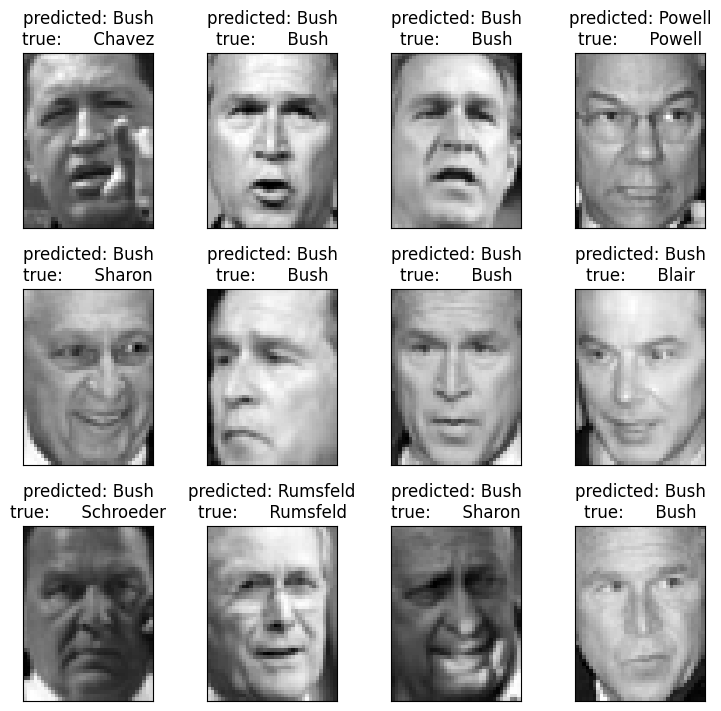

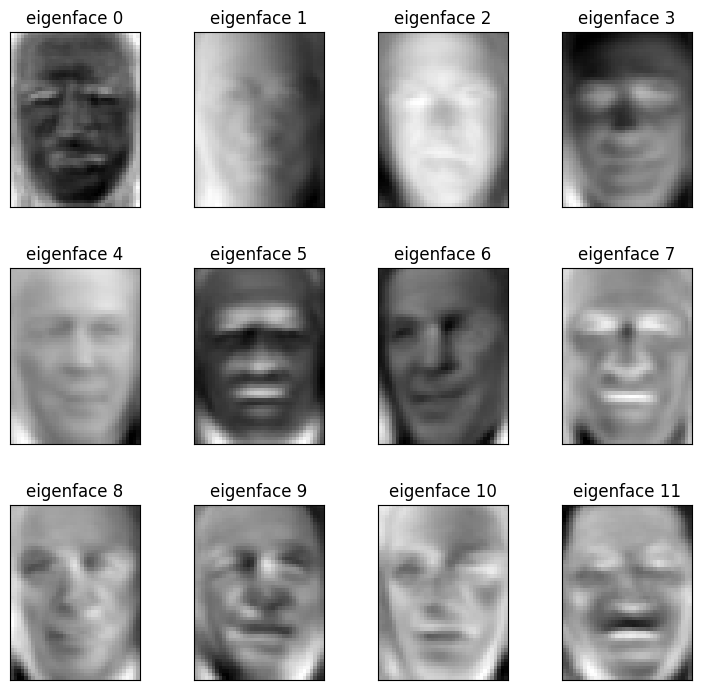

In [14]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

def title(y_pred, y_test, target_names, i):
  pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
  true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
  return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

# Plot the result of the prediction on a portion of the test set
eigenface_titles = ['eigenface %d' % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()